# Batch variant scoring

In this notebook, we demonstrate how to score many variants using AlphaGenome.

To prepare numerous variants for scoring, provide the following information as
columns in a tab-separated Variant Call Format (VCF) file: - `variant_id`: A
unique identifier for each variant. - `CHROM`: Chromosome, specified as a string
beginning with 'chr' (e.g., 'chr1'). - `POS`: Integer representing the base pair
position (1-based; build hg38 (human) or mm10 (mouse) - see
[FAQ](https://www.alphagenomedocs.com/faqs.html#how-do-i-define-a-variant)). -
`REF`: The reference nucleotide sequence at the specified position. - `ALT`: The
alternate nucleotide sequence at the specified position.

``` {tip}
Open this tutorial in Google colab for interactive viewing.
```

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

In [2]:
# @title Setup and imports.

from io import StringIO
from alphagenome import colab_utils
from alphagenome.data import genome
from alphagenome.models import dna_client, variant_scorers
from google.colab import data_table, files
import pandas as pd
from tqdm import tqdm

data_table.enable_dataframe_formatter()

# Load the model.
dna_model = dna_client.create(colab_utils.get_api_key())

In [3]:
import pandas as pd
eqtl = pd.read_csv('wholeblood.txt', sep='\t')
eqtl_filtered = eqtl[eqtl['pip'] > 0.9].copy()
eqtl_filtered = eqtl_filtered[['variant_id', 'phenotype_id', 'gene_name', 'pip']]
print(eqtl_filtered.head())
print(f"Total variants with PIP>0.9: {len(eqtl_filtered)}")


            variant_id       phenotype_id        gene_name       pip
0  chr1_666028_G_A_b38  ENSG00000227232.5           WASH7P  0.974511
1   chr1_63671_G_A_b38  ENSG00000238009.6  ENSG00000238009  0.971531
4  chr1_282564_C_A_b38  ENSG00000238009.6  ENSG00000238009  0.990876
5  chr1_277801_G_A_b38  ENSG00000233750.3           CICP27  1.000000
6  chr1_135203_G_A_b38  ENSG00000268903.1  ENSG00000268903  0.994966
Total variants with PIP>0.9: 3075


In [4]:
# variant_id = chr_pos_ref_alt_b38
def split_var(v):
    parts = v.split('_')
    # chr, pos, ref, alt assumed
    return pd.Series({
        'variant_id': v,
        'CHROM': parts[0],
        'POS': int(parts[1]),
        'REF': parts[2],
        'ALT': parts[3]
    })

vcf_input = eqtl_filtered['variant_id'].apply(split_var)


In [5]:
vcf_input.to_csv('vcf_input.tsv', sep='\t', index=False)

In [7]:
import pandas as pd
import numpy as np
vcf_full = pd.read_csv('vcf_input.tsv', sep="\t")  # 改为tsv如果你是TSV
batches = np.array_split(vcf_full, 30)
for i, batch in enumerate(batches):
    filename = f"vcf_input_batch_{i+1}.csv"
    batch.to_csv(filename, sep="\t", index=False)
    print(f"✅ Saved: {filename}, size = {batch.shape[0]} variants")


✅ Saved: vcf_input_batch_1.csv, size = 103 variants
✅ Saved: vcf_input_batch_2.csv, size = 103 variants
✅ Saved: vcf_input_batch_3.csv, size = 103 variants
✅ Saved: vcf_input_batch_4.csv, size = 103 variants
✅ Saved: vcf_input_batch_5.csv, size = 103 variants
✅ Saved: vcf_input_batch_6.csv, size = 103 variants
✅ Saved: vcf_input_batch_7.csv, size = 103 variants
✅ Saved: vcf_input_batch_8.csv, size = 103 variants
✅ Saved: vcf_input_batch_9.csv, size = 103 variants
✅ Saved: vcf_input_batch_10.csv, size = 103 variants
✅ Saved: vcf_input_batch_11.csv, size = 103 variants
✅ Saved: vcf_input_batch_12.csv, size = 103 variants
✅ Saved: vcf_input_batch_13.csv, size = 103 variants
✅ Saved: vcf_input_batch_14.csv, size = 103 variants
✅ Saved: vcf_input_batch_15.csv, size = 103 variants
✅ Saved: vcf_input_batch_16.csv, size = 102 variants
✅ Saved: vcf_input_batch_17.csv, size = 102 variants
✅ Saved: vcf_input_batch_18.csv, size = 102 variants
✅ Saved: vcf_input_batch_19.csv, size = 102 variants
✅ 

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:


vcf = pd.read_csv('', sep='\t')

required_columns = ['variant_id', 'CHROM', 'POS', 'REF', 'ALT']
for column in required_columns:
  if column not in vcf.columns:
    raise ValueError(f'VCF file is missing required column: {column}.')

organism = 'human'  # @param ["human", "mouse"] {type:"string"}

# @markdown Specify length of sequence around variants to predict:
sequence_length = '1MB'  # @param ["2KB", "16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# @markdown Specify which scorers to use to score your variants:
score_rna_seq = True  # @param { type: "boolean"}
score_cage = False  # @param { type: "boolean" }
score_procap = False  # @param { type: "boolean" }
score_atac = False  # @param { type: "boolean" }
score_dnase = False  # @param { type: "boolean" }
score_chip_histone = False  # @param { type: "boolean" }
score_chip_tf = False  # @param { type: "boolean" }
score_polyadenylation = False  # @param { type: "boolean" }
score_splice_sites = False  # @param { type: "boolean" }
score_splice_site_usage = False  # @param { type: "boolean" }
score_splice_junctions = False  # @param { type: "boolean" }

# @markdown Other settings:
download_predictions = False  # @param { type: "boolean" }

# Parse organism specification.
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
    'mouse': dna_client.Organism.MUS_MUSCULUS,
}
organism = organism_map[organism]

# Parse scorer specification.
scorer_selections = {
    'rna_seq': score_rna_seq,
    'cage': score_cage,
    'procap': score_procap,
    'atac': score_atac,
    'dnase': score_dnase,
    'chip_histone': score_chip_histone,
    'chip_tf': score_chip_tf,
    'polyadenylation': score_polyadenylation,
    'splice_sites': score_splice_sites,
    'splice_site_usage': score_splice_site_usage,
    'splice_junctions': score_splice_junctions,
}

all_scorers = variant_scorers.RECOMMENDED_VARIANT_SCORERS
selected_scorers = [
    all_scorers[key]
    for key in all_scorers
    if scorer_selections.get(key.lower(), False)
]

# Remove any scorers or output types that are not supported for the chosen organism.
unsupported_scorers = [
    scorer
    for scorer in selected_scorers
    if (
        organism.value
        not in variant_scorers.SUPPORTED_ORGANISMS[scorer.base_variant_scorer]
    )
    | (
        (scorer.requested_output == dna_client.OutputType.PROCAP)
        & (organism == dna_client.Organism.MUS_MUSCULUS)
    )
]
if len(unsupported_scorers) > 0:
  print(
      f'Excluding {unsupported_scorers} scorers as they are not supported for'
      f' {organism}.'
  )
  for unsupported_scorer in unsupported_scorers:
    selected_scorers.remove(unsupported_scorer)


# Score variants in the VCF file.
results = []

for i, vcf_row in tqdm(vcf.iterrows(), total=len(vcf)):
  variant = genome.Variant(
      chromosome=str(vcf_row.CHROM),
      position=int(vcf_row.POS),
      reference_bases=vcf_row.REF,
      alternate_bases=vcf_row.ALT,
      name=vcf_row.variant_id,
  )
  interval = variant.reference_interval.resize(sequence_length)

  variant_scores = dna_model.score_variant(
      interval=interval,
      variant=variant,
      variant_scorers=selected_scorers,
      organism=organism,
  )
  results.append(variant_scores)

df_scores = variant_scorers.tidy_scores(results)

if download_predictions:
  df_scores.to_csv('variant_scores.csv', index=False)
  files.download('variant_scores.csv')

df_scores

100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000084 ATAC-seq,.,ATAC-seq,CL:0000084,T-cell,primary_cell,NaN,NaN,NaN,-0.003778,-0.215740
1,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000100 ATAC-seq,.,ATAC-seq,CL:0000100,motor neuron,in_vitro_differentiated_cells,NaN,NaN,NaN,0.012303,0.280661
2,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000236 ATAC-seq,.,ATAC-seq,CL:0000236,B cell,primary_cell,NaN,NaN,NaN,-0.000334,-0.080577
3,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000623 ATAC-seq,.,ATAC-seq,CL:0000623,natural killer cell,primary_cell,NaN,NaN,NaN,-0.009233,-0.440600
4,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000624 ATAC-seq,.,ATAC-seq,CL:0000624,"CD4-positive, alpha-beta T cell",primary_cell,NaN,NaN,NaN,-0.010510,-0.440600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121951,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292423,ENSG00000292423,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0036149 gtex Skin_Not_Sun_Exposed_Supra...,.,polyA plus RNA-seq,UBERON:0036149,suprapubic skin,tissue,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,0.000052,0.069106
121952,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292430,ENSG00000292430,lncRNA,+,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0036149 gtex Skin_Not_Sun_Exposed_Supra...,.,polyA plus RNA-seq,UBERON:0036149,suprapubic skin,tissue,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,0.004865,0.963724
121953,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292431,ENSG00000292431,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0036149 gtex Skin_Not_Sun_Exposed_Supra...,.,polyA plus RNA-seq,UBERON:0036149,suprapubic skin,tissue,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,-0.000141,-0.137554
121954,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292432,ENSG00000292432,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0036149 gtex Skin_Not_Sun_Exposed_Supra...,.,polyA plus RNA-seq,UBERON:0036149,suprapubic skin,tissue,NaN,NaN,Skin_Not_Sun_Exposed_Suprapubic,0.000508,0.363304


In [ ]:
from google.colab import files
import gc

ontology_target = "UBERON:0013756"   # Whole Blood 对应本体
for batch_id in range(1, 31):
    print(f"\n🚀 Processing batch {batch_id}/30 ...")
        # 1) 读取这一批
    vcf = pd.read_csv(f"vcf_input_batch_{batch_id}.csv", sep="\t")

    # 2) 调用 AlphaGenome 预测（保持你之前那段 scoring 代码）
    results = []

    for i, vcf_row in tqdm(vcf.iterrows(), total=len(vcf)):


Note that the resulting output dataframe could be quite large, especially if you
use many scorers for scoring. Very large dataframes can't be filtered
interactively, but you can interact with them using the standard `pandas`
commands:

In [ ]:
# Examine just the effects of the variants on T-cells.
columns = [c for c in df_scores.columns if c != 'ontology_curie']
df_scores[(df_scores['ontology_curie'] == 'CL:0000084')][columns]

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,biosample_name,biosample_type,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000084 ATAC-seq,.,ATAC-seq,T-cell,primary_cell,NaN,NaN,NaN,-0.003778,-0.215740
168,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,DNASE,"CenterMaskScorer(requested_output=DNASE, width...",CL:0000084 DNase-seq,.,DNase-seq,T-cell,primary_cell,NaN,NaN,NaN,-0.030633,-0.680793
2109,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,CHIP_HISTONE,CenterMaskScorer(requested_output=CHIP_HISTONE...,CL:0000084 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,T-cell,primary_cell,NaN,H3K27ac,NaN,-0.001469,-0.373276
2110,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,CHIP_HISTONE,CenterMaskScorer(requested_output=CHIP_HISTONE...,CL:0000084 Histone ChIP-seq H3K27me3,.,Histone ChIP-seq,T-cell,primary_cell,NaN,H3K27me3,NaN,0.001324,0.171333
2111,chr3:58394738:A>T,chr3:57870450-58919026:.,None,None,None,None,None,None,CHIP_HISTONE,CenterMaskScorer(requested_output=CHIP_HISTONE...,CL:0000084 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,T-cell,primary_cell,NaN,H3K36me3,NaN,-0.002098,-0.383161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95033,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000290756,ENSG00000290756,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,T-cell,primary_cell,NaN,NaN,,-0.000237,-0.312224
95034,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292400,ENSG00000292400,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,T-cell,primary_cell,NaN,NaN,,0.000030,0.126219
95035,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292423,ENSG00000292423,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,T-cell,primary_cell,NaN,NaN,,0.000173,0.280661
95036,chr16:1135446:G>T,chr16:611158-1659734:.,ENSG00000292431,ENSG00000292431,lncRNA,-,None,None,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),CL:0000084 total RNA-seq,-,total RNA-seq,T-cell,primary_cell,NaN,NaN,,-0.000035,-0.126219


In [8]:
import pandas as pd
import gc
from tqdm import tqdm
from google.colab import files

WHOLE_BLOOD_UBERON = "UBERON:0013756"

import glob
batch_files = sorted(glob.glob("vcf_input_batch_*.csv"), key=lambda x: int(x.split("_")[-1].split(".")[0]))

print(f"Found {len(batch_files)} batch files:")
print(batch_files)

Found 30 batch files:
['vcf_input_batch_1.csv', 'vcf_input_batch_2.csv', 'vcf_input_batch_3.csv', 'vcf_input_batch_4.csv', 'vcf_input_batch_5.csv', 'vcf_input_batch_6.csv', 'vcf_input_batch_7.csv', 'vcf_input_batch_8.csv', 'vcf_input_batch_9.csv', 'vcf_input_batch_10.csv', 'vcf_input_batch_11.csv', 'vcf_input_batch_12.csv', 'vcf_input_batch_13.csv', 'vcf_input_batch_14.csv', 'vcf_input_batch_15.csv', 'vcf_input_batch_16.csv', 'vcf_input_batch_17.csv', 'vcf_input_batch_18.csv', 'vcf_input_batch_19.csv', 'vcf_input_batch_20.csv', 'vcf_input_batch_21.csv', 'vcf_input_batch_22.csv', 'vcf_input_batch_23.csv', 'vcf_input_batch_24.csv', 'vcf_input_batch_25.csv', 'vcf_input_batch_26.csv', 'vcf_input_batch_27.csv', 'vcf_input_batch_28.csv', 'vcf_input_batch_29.csv', 'vcf_input_batch_30.csv']


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from google.colab import files
import gc

WHOLE_BLOOD_UBERON = "UBERON:0013756"

import glob
batch_files = sorted(glob.glob("vcf_input_batch_*.csv"), key=lambda x: int(x.split("_")[-1].split(".")[0]))
print(f"Detected {len(batch_files)} batch files:", batch_files)


for idx, batch_file in enumerate(batch_files, start=1):
    print(f"\n🚀 Processing {batch_file} ({idx}/{len(batch_files)})")


    vcf_batch = pd.read_csv(batch_file, sep="\t")


    required_columns = ['variant_id', 'CHROM', 'POS', 'REF', 'ALT']
    for column in required_columns:
        if column not in vcf_batch.columns:
            raise ValueError(f'VCF file is missing required column: {column}.')


    organism = 'human'
    sequence_length = '1MB'
    sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[f'SEQUENCE_LENGTH_{sequence_length}']

    score_rna_seq = True
    score_cage = False
    score_procap = False
    score_atac = False
    score_dnase = False
    score_chip_histone = False
    score_chip_tf = False
    score_polyadenylation = False
    score_splice_sites = False
    score_splice_site_usage = False
    score_splice_junctions = False

    download_predictions = False

    organism_map = {
        'human': dna_client.Organism.HOMO_SAPIENS,
        'mouse': dna_client.Organism.MUS_MUSCULUS,
    }
    organism = organism_map[organism]

    scorer_selections = {
        'rna_seq': score_rna_seq,
        'cage': score_cage,
        'procap': score_procap,
        'atac': score_atac,
        'dnase': score_dnase,
        'chip_histone': score_chip_histone,
        'chip_tf': score_chip_tf,
        'polyadenylation': score_polyadenylation,
        'splice_sites': score_splice_sites,
        'splice_site_usage': score_splice_site_usage,
        'splice_junctions': score_splice_junctions,
    }

    all_scorers = variant_scorers.RECOMMENDED_VARIANT_SCORERS
    selected_scorers = [
        all_scorers[key]
        for key in all_scorers
        if scorer_selections.get(key.lower(), False)
    ]

    unsupported_scorers = [
        scorer
        for scorer in selected_scorers
        if (
            organism.value
            not in variant_scorers.SUPPORTED_ORGANISMS[scorer.base_variant_scorer]
        )
        | (
            (scorer.requested_output == dna_client.OutputType.PROCAP)
            & (organism == dna_client.Organism.MUS_MUSCULUS)
        )
    ]
    if len(unsupported_scorers) > 0:
        print(f'Excluding {unsupported_scorers} scorers as they are not supported for {organism}.')
        for unsupported_scorer in unsupported_scorers:
            selected_scorers.remove(unsupported_scorer)

    # === Run AlphaGenome ===
    results = []
    for i, vcf_row in tqdm(vcf_batch.iterrows(), total=len(vcf_batch)):
        variant = genome.Variant(
            chromosome=str(vcf_row.CHROM),
            position=int(vcf_row.POS),
            reference_bases=vcf_row.REF,
            alternate_bases=vcf_row.ALT,
            name=vcf_row.variant_id,
        )
        interval = variant.reference_interval.resize(sequence_length)

        variant_scores = dna_model.score_variant(
            interval=interval,
            variant=variant,
            variant_scorers=selected_scorers,
            organism=organism,
        )
        results.append(variant_scores)

    df_scores = variant_scorers.tidy_scores(results)

    # === 过滤 Whole Blood ===
    df_wholeblood = df_scores[df_scores["ontology_curie"] == WHOLE_BLOOD_UBERON]

    # === 保存并下载 ===
    out_file = f"AlphaGenome_WholeBlood_{batch_file.replace('.csv', '')}.tsv"
    df_wholeblood.to_csv(out_file, sep="\t", index=False)

    # === 清理内存 ===
    del df_wholeblood, df_scores, vcf_batch, results
    gc.collect()

print("\n🎉 All batch predictions completed!")


Detected 30 batch files: ['vcf_input_batch_1.csv', 'vcf_input_batch_2.csv', 'vcf_input_batch_3.csv', 'vcf_input_batch_4.csv', 'vcf_input_batch_5.csv', 'vcf_input_batch_6.csv', 'vcf_input_batch_7.csv', 'vcf_input_batch_8.csv', 'vcf_input_batch_9.csv', 'vcf_input_batch_10.csv', 'vcf_input_batch_11.csv', 'vcf_input_batch_12.csv', 'vcf_input_batch_13.csv', 'vcf_input_batch_14.csv', 'vcf_input_batch_15.csv', 'vcf_input_batch_16.csv', 'vcf_input_batch_17.csv', 'vcf_input_batch_18.csv', 'vcf_input_batch_19.csv', 'vcf_input_batch_20.csv', 'vcf_input_batch_21.csv', 'vcf_input_batch_22.csv', 'vcf_input_batch_23.csv', 'vcf_input_batch_24.csv', 'vcf_input_batch_25.csv', 'vcf_input_batch_26.csv', 'vcf_input_batch_27.csv', 'vcf_input_batch_28.csv', 'vcf_input_batch_29.csv', 'vcf_input_batch_30.csv']

🚀 Processing vcf_input_batch_1.csv (1/30)


100%|██████████| 103/103 [02:34<00:00,  1.50s/it]



🚀 Processing vcf_input_batch_2.csv (2/30)


100%|██████████| 103/103 [02:32<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_3.csv (3/30)


100%|██████████| 103/103 [02:33<00:00,  1.49s/it]



🚀 Processing vcf_input_batch_4.csv (4/30)


100%|██████████| 103/103 [02:32<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_5.csv (5/30)


100%|██████████| 103/103 [02:33<00:00,  1.49s/it]



🚀 Processing vcf_input_batch_6.csv (6/30)


100%|██████████| 103/103 [02:32<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_7.csv (7/30)


100%|██████████| 103/103 [02:29<00:00,  1.45s/it]



🚀 Processing vcf_input_batch_8.csv (8/30)


100%|██████████| 103/103 [02:32<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_9.csv (9/30)


100%|██████████| 103/103 [02:37<00:00,  1.53s/it]



🚀 Processing vcf_input_batch_10.csv (10/30)


100%|██████████| 103/103 [02:31<00:00,  1.47s/it]



🚀 Processing vcf_input_batch_11.csv (11/30)


100%|██████████| 103/103 [02:31<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_12.csv (12/30)


100%|██████████| 103/103 [02:31<00:00,  1.47s/it]



🚀 Processing vcf_input_batch_13.csv (13/30)


100%|██████████| 103/103 [02:33<00:00,  1.49s/it]



🚀 Processing vcf_input_batch_14.csv (14/30)


100%|██████████| 103/103 [02:34<00:00,  1.50s/it]



🚀 Processing vcf_input_batch_15.csv (15/30)


100%|██████████| 103/103 [02:35<00:00,  1.51s/it]



🚀 Processing vcf_input_batch_16.csv (16/30)


100%|██████████| 102/102 [02:33<00:00,  1.51s/it]



🚀 Processing vcf_input_batch_17.csv (17/30)


100%|██████████| 102/102 [02:32<00:00,  1.49s/it]



🚀 Processing vcf_input_batch_18.csv (18/30)


100%|██████████| 102/102 [02:33<00:00,  1.50s/it]



🚀 Processing vcf_input_batch_19.csv (19/30)


100%|██████████| 102/102 [02:32<00:00,  1.50s/it]



🚀 Processing vcf_input_batch_20.csv (20/30)


100%|██████████| 102/102 [02:36<00:00,  1.54s/it]



🚀 Processing vcf_input_batch_21.csv (21/30)


100%|██████████| 102/102 [02:33<00:00,  1.51s/it]



🚀 Processing vcf_input_batch_22.csv (22/30)


100%|██████████| 102/102 [02:34<00:00,  1.52s/it]



🚀 Processing vcf_input_batch_23.csv (23/30)


100%|██████████| 102/102 [02:33<00:00,  1.51s/it]



🚀 Processing vcf_input_batch_24.csv (24/30)


100%|██████████| 102/102 [02:33<00:00,  1.50s/it]



🚀 Processing vcf_input_batch_25.csv (25/30)


100%|██████████| 102/102 [02:36<00:00,  1.53s/it]



🚀 Processing vcf_input_batch_26.csv (26/30)


100%|██████████| 102/102 [02:37<00:00,  1.55s/it]



🚀 Processing vcf_input_batch_27.csv (27/30)


100%|██████████| 102/102 [02:35<00:00,  1.53s/it]



🚀 Processing vcf_input_batch_28.csv (28/30)


100%|██████████| 102/102 [02:30<00:00,  1.48s/it]



🚀 Processing vcf_input_batch_29.csv (29/30)


100%|██████████| 102/102 [02:32<00:00,  1.49s/it]



🚀 Processing vcf_input_batch_30.csv (30/30)


100%|██████████| 102/102 [02:31<00:00,  1.48s/it]



🎉 All batch predictions completed!


In [16]:
import pandas as pd
import glob

result_files = sorted(glob.glob("AlphaGenome_WholeBlood_*.tsv"))
print(f"Found {len(result_files)} result files")


df_list = []
for f in result_files:
    print(f"Reading: {f}")
    temp_df = pd.read_csv(f, sep="\t")
    df_list.append(temp_df)


df_merged = pd.concat(df_list, ignore_index=True)


merged_output = "AlphaGenome_WholeBlood_merged.csv"
df_merged.to_csv(merged_output, index=False)

print(f"\n Successfully merged! Final shape: {df_merged.shape}")
print(f" Saved: {merged_output}")


Found 30 result files
Reading: AlphaGenome_WholeBlood_vcf_input_batch_1.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_10.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_11.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_12.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_13.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_14.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_15.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_16.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_17.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_18.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_19.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_2.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_20.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_21.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_22.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_23.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_batch_24.tsv
Reading: AlphaGenome_WholeBlood_vcf_input_bat

In [25]:
df_merged

,variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,gtex_tissue,raw_score,quantile_score
0,chr1:666028:G>A,chr1:141740-1190316:.,ENSG00000131591,C1orf159,protein_coding,-,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,-0.001215,-0.591924
1,chr1:666028:G>A,chr1:141740-1190316:.,ENSG00000162571,TTLL10,protein_coding,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,0.000774,0.468060
2,chr1:666028:G>A,chr1:141740-1190316:.,ENSG00000177757,FAM87B,lncRNA,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,0.000229,0.226711
3,chr1:666028:G>A,chr1:141740-1190316:.,ENSG00000187583,PLEKHN1,protein_coding,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,-0.001844,-0.721776
4,chr1:666028:G>A,chr1:141740-1190316:.,ENSG00000187608,ISG15,protein_coding,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,0.004060,0.925572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140363,chr6:57221614:C>G,chr6:56697326-57745902:.,ENSG00000219790,OSTCP6,processed_pseudogene,-,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,-0.000172,-0.171333
140364,chr6:57221614:C>G,chr6:56697326-57745902:.,ENSG00000226803,ZNF451-AS1,lncRNA,-,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,-0.002904,-0.853515
140365,chr6:57221614:C>G,chr6:56697326-57745902:.,ENSG00000231441,DST-AS1,lncRNA,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,-0.000439,-0.322597
140366,chr6:57221614:C>G,chr6:56697326-57745902:.,ENSG00000266579,ENSG00000266579,lncRNA,+,NaN,NaN,RNA_SEQ,GeneMaskLFCScorer(requested_output=RNA_SEQ),UBERON:0013756 gtex Whole_Blood polyA plus RNA...,.,polyA plus RNA-seq,UBERON:0013756,venous blood,tissue,Whole_Blood,0.001167,0.584379


In [34]:
import pandas as pd
import glob
from scipy.stats import spearmanr
import numpy as np

eqtl = pd.read_csv("wholeblood.txt", sep="\t")


eqtl["phenotype_id"] = eqtl["phenotype_id"].str.split('.').str[0]


eqtl = eqtl[eqtl["pip"] > 0.9].copy()
print(f"✅ GTEx GTEx PIP>0.9 entries: {eqtl.shape}")


pred = pd.read_csv("AlphaGenome_WholeBlood_merged.csv")

print(f"✅ AlphaGenome Whole Blood predicted rows: {pred.shape}")

def convert_variant_id(s):

    chrom, pos, ref_alt = s.split(":")
    ref, alt = ref_alt.split(">")
    return f"{chrom}_{pos}_{ref}_{alt}_b38"

pred["variant_id"] = pred["variant_id"].apply(convert_variant_id)


merged = pred.merge(
    eqtl,
    left_on=["variant_id", "gene_id"],          # AlphaGenome
    right_on=["variant_id", "phenotype_id"],    # GTEx cleaned
    how="inner"
)

print(f" Successfully merged rows: {merged.shape}")

rho, pval = spearmanr(merged["raw_score"], merged["afc"])
print("\nSpearman correlation:")
print(f"   ➤ rho = {rho:.4f}, p-value = {pval:.2e}")

merged["same_direction"] = (merged["raw_score"].gt(0) == merged["afc"].gt(0))
direction_rate = merged["same_direction"].mean()
print(f"Effect direction agreement rate = {direction_rate:.2%}")

merged.to_csv("AlphaGenome_GTEx_WholeBlood_merged_scores.tsv", sep="\t", index=False)
print("Output saved: AlphaGenome_GTEx_WholeBlood_merged_scores.tsv")
print("Columns include: variant_id, gene_id, raw_score, afc, pip, same_direction etc.")


✅ GTEx GTEx PIP>0.9 entries: (3075, 10)
✅ AlphaGenome Whole Blood predicted rows: (140368, 19)
 Successfully merged rows: (3680, 28)

Spearman correlation:
   ➤ rho = 0.5049, p-value = 2.61e-237
Effect direction agreement rate = 70.43%
Output saved: AlphaGenome_GTEx_WholeBlood_merged_scores.tsv
Columns include: variant_id, gene_id, raw_score, afc, pip, same_direction etc.


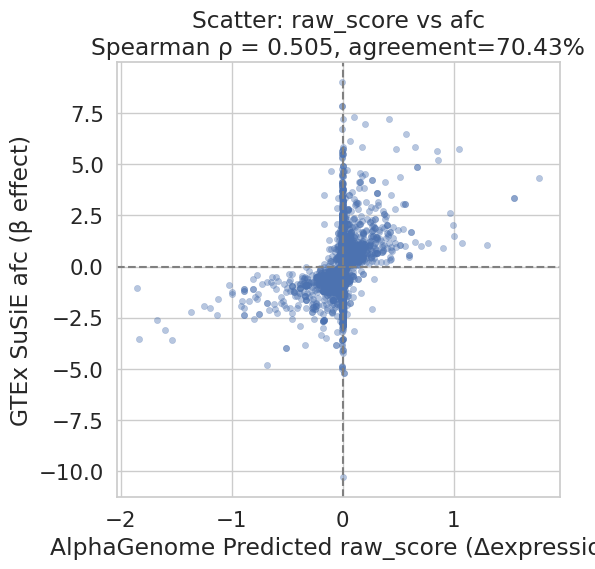

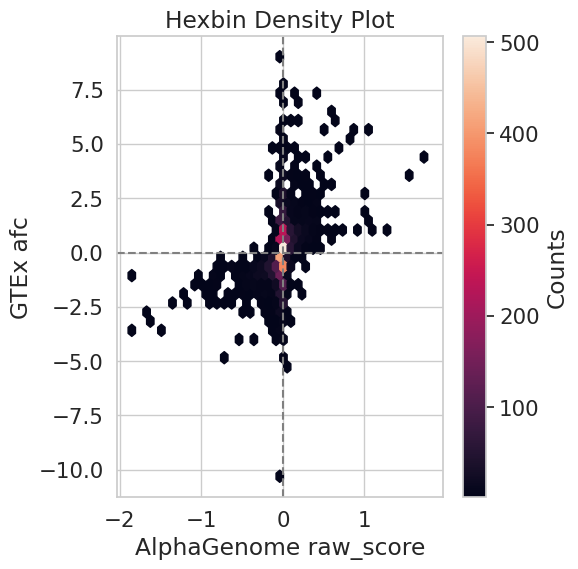

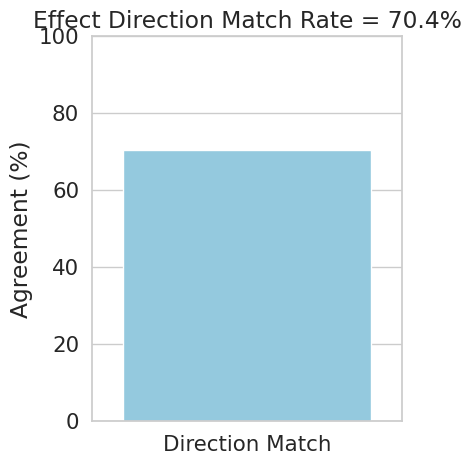

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid", font_scale=1.4)


plt.figure(figsize=(6,6))
sns.scatterplot(
    data=merged,
    x="raw_score", y="afc",
    alpha=0.4, s=20, edgecolor=None
)
plt.xlabel("AlphaGenome Predicted raw_score (Δexpression)")
plt.ylabel("GTEx SuSiE afc (β effect)")
plt.title(f"Scatter: raw_score vs afc\nSpearman ρ = {rho:.3f}, agreement={direction_rate:.2%}")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.savefig("scatter_raw_vs_afc.png", dpi=300)
plt.show()


plt.figure(figsize=(6,6))
plt.hexbin(
    merged["raw_score"], merged["afc"],
    gridsize=40, mincnt=1
)
plt.xlabel("AlphaGenome raw_score")
plt.ylabel("GTEx afc")
plt.title("Hexbin Density Plot")
cb = plt.colorbar()
cb.set_label("Counts")
plt.axhline(0, color="grey", linestyle="--")
plt.axvline(0, color="grey", linestyle="--")
plt.tight_layout()
plt.savefig("hexbin_raw_vs_afc.png", dpi=300)
plt.show()


plt.figure(figsize=(4,5))
agree_rate = direction_rate * 100  # %
sns.barplot(x=["Direction Match"], y=[agree_rate], color="skyblue")
plt.ylabel("Agreement (%)")
plt.ylim(0, 100)
plt.title(f"Effect Direction Match Rate = {agree_rate:.1f}%")
plt.savefig("direction_agreement_bar.png", dpi=300)
plt.show()


In [28]:
pred

,"variant_id,scored_interval,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,Assay title,ontology_curie,biosample_name,biosample_type,gtex_tissue,raw_score,quantile_score"
0,"chr1:666028:G>A,chr1:141740-1190316:.,ENSG0000..."
1,"chr1:666028:G>A,chr1:141740-1190316:.,ENSG0000..."
2,"chr1:666028:G>A,chr1:141740-1190316:.,ENSG0000..."
3,"chr1:666028:G>A,chr1:141740-1190316:.,ENSG0000..."
4,"chr1:666028:G>A,chr1:141740-1190316:.,ENSG0000..."
...,...
140363,"chr6:57221614:C>G,chr6:56697326-57745902:.,ENS..."
140364,"chr6:57221614:C>G,chr6:56697326-57745902:.,ENS..."
140365,"chr6:57221614:C>G,chr6:56697326-57745902:.,ENS..."
140366,"chr6:57221614:C>G,chr6:56697326-57745902:.,ENS..."
